<a href="https://colab.research.google.com/github/AnmarAl-Adly/gpytorch/blob/master/Copy_of_Final_beam_Sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 ! pip install pyDOE
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu


In [ ]:
steps=200
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=0
x_max=1
t_min=0
t_max=0.15
total_points_x=100
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
#Ni=150
Nu=150
Nf=22500

alphaI =1
alphaB =1 
alphaG =2e-4

In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def solutionplot(arr_y_test,X_train_Nu,Y_train_Nu):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(arr_y_test, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_train_Nu[:,1], X_train_Nu[:,0], 'kx', label = 'Data (%d points)' % (Y_train_Nu.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$f(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.0375, t = 0.075 and t = 0.1125
    '''
    
    ####### Row 1: f(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/2, bottom=0, left=0.1, right=0.9, wspace=1)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,y_real.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,arr_y_test.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x,t)$')    
    ax.set_title('$t = 0.0375s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,y_real.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,arr_y_test.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x,t)$')
    ax.axis('square')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.075s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,y_real.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,arr_y_test.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x,t)$')
    ax.axis('square')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.1125s$', fontsize = 10)
    
    #plt.savefig('Burgers.png',dpi = 500)   

In [ ]:
def f_real(x,t):
  return torch.sin(np.pi*x*3)*(torch.cos(np.pi**2*t*9))


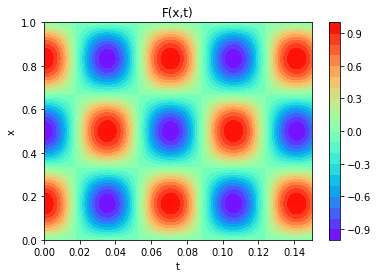

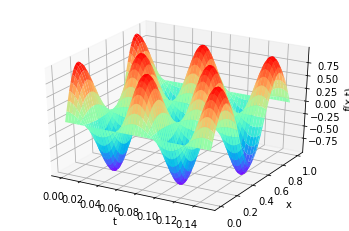

In [ ]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X,T)
plot3D(x,t,y_real) #f_real was defined previously(function)

In [ ]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 100])
torch.Size([100, 100]) torch.Size([100, 100])


In [ ]:
class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
   
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_xxx_ttt =autograd.grad(f_xx_tt,g,torch.ones(g.shape).to(device), create_graph=True)[0] #third derivative
      f_xxxx_tttt = autograd.grad(f_xxx_ttt,g,torch.ones(g.shape).to(device), create_graph=True)[0]
     
      f_tt=f_xx_tt[:,[1]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f_xxxx=f_xxxx_tttt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f=f_xxxx+f_tt
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
     
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return alphaB*loss_bc+alphaG*loss_pde
    
    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss   
 
         
  

In [ ]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 
print(x_test.shape,y_test.shape)
print(lb,ub)



torch.Size([10000, 2]) torch.Size([10000, 1])
tensor([0., 0.]) tensor([1.0000, 0.1500])


In [ ]:
#Initial Condition
#Left Edge: x(x,0)=sin(3*pi*x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*3*left_X[:,0]).unsqueeze(1)
#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)
#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

In [ ]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution 


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
0.14997196 --- 0.25968683
0.14521956 --- 0.25969747
0.14335744 --- 0.25982022
0.1424423 --- 0.26075056
0.14196646 --- 0.26151153
0.14156751 --- 0.26189232
0.14111322 --- 0.26205075
0.14054242 --- 0.26228225
0.13982089 --- 0.26281548
0.13894388 --- 0.26391256


In [ ]:
y1=PINN(X_test)

In [ ]:
x1=X_test[:,0]
t1=X_test[:,1]

In [ ]:
arr_x1=x1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,100]).transpose(1,0).detach().cpu()

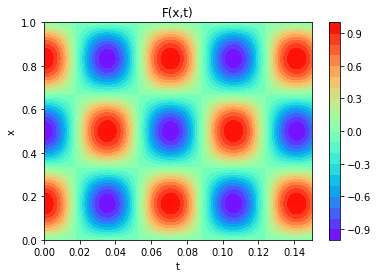

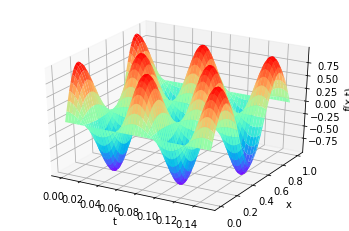

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,arr_y_test)

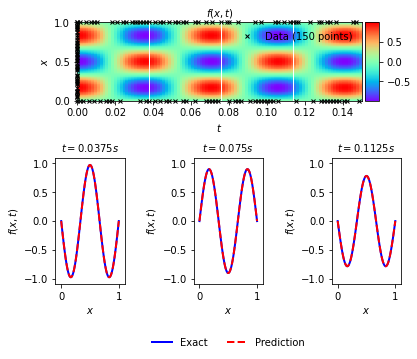

In [ ]:
solutionplot(arr_y_test,X_train_Nu,Y_train_Nu)

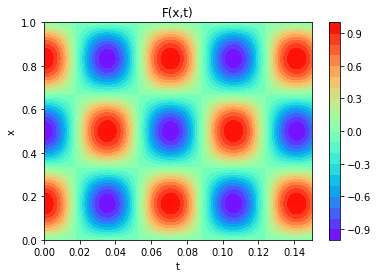

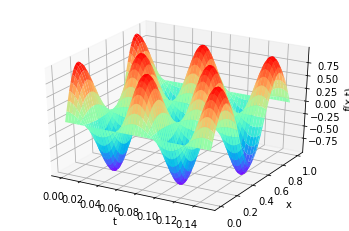

In [ ]:
plot3D_Matrix(X,T,y_real)